In [244]:
import pandas as pd 
import json
import matplotlib.pyplot as plt
import networkx as nx
import re

DATA_DIR = '/content/jupyter/mta-accessibility/'

In [245]:
elevators = pd.read_csv(DATA_DIR+'data/interim/crosswalks/EE_master_list.csv')
# discard escalators
elevators = elevators[ (elevators.equipment_type == 'EL') & (elevators.is_active == 'Y') ] # & (elevators.ada_compliant == 'Y')
# discard columns we don't need
elevators = elevators[["station_name", "equipment_id", "description", "connection_to_street"]]
elevators.head(25)

,station_name,equipment_id,description,connection_to_street
0,125 St,EL125,125 St & Lexington Ave (NE corner) to Mezzanin...,Y
1,125 St,EL142,125 St & St Nicholas Ave (SW corner) to Mezzan...,Y
2,125 St,EL143,Mezzanine to downtown Platform,N
3,125 St,EL126,Mezzanine to Platforms for service in both dir...,N
4,125 St,EL144,Mezzanine to uptown Platform,N
8,135 St,EL180,Lenox Ave & 181 St (NE corner) to uptown Platform,N
9,135 St,EL181,Lenox Ave & 181 St (SW corner) to downtown Pla...,N
10,14 St - 8 Av,EL221,8th Ave & 14 St (SW corner) to Mezzanine for s...,N
11,14 St - 8 Av,EL222,Mezzanine to downtown A/C/E Platform,N
12,14 St - 8 Av,EL223,Mezzanine to uptown A/C/E Platform,N


In [246]:
mapped_elevators = pd.read_csv(DATA_DIR+'data/processed/elevator_to_line_dir_station.csv')
mapped_elevators.head()

,Unnamed: 0,equipment_id,line,direction,station
0,230,EL103,1,south,191 St
1,21,EL103,1,north,191 St
2,185,EL122,6,manhattan,Pelham Bay Park
3,18,EL124,A,north,175 St
4,628,EL126,5,south,125 St


In [247]:
# the MTA direction information is incomplete!
platform_ids = mapped_elevators[['equipment_id', 'line', 'direction']].set_index('equipment_id')
platform_ids = platform_ids.apply(lambda t : '-'.join(t), axis=1).groupby(level=0).unique()
platform_ids = platform_ids.apply(lambda t : '/'.join(t))
elevators.set_index('equipment_id', inplace=True)
elevators['platform_id'] = platform_ids
elevators.reset_index(inplace=True)
elevators.head()

,equipment_id,station_name,description,connection_to_street,platform_id
0,EL125,125 St,125 St & Lexington Ave (NE corner) to Mezzanin...,Y,NaN
1,EL142,125 St,125 St & St Nicholas Ave (SW corner) to Mezzan...,Y,NaN
2,EL143,125 St,Mezzanine to downtown Platform,N,A-south/D-south/B-south/C-south
3,EL126,125 St,Mezzanine to Platforms for service in both dir...,N,5-south/4-north/5-north/METRO-NORTH-south/METR...
4,EL144,125 St,Mezzanine to uptown Platform,N,C-north/B-north/A-north/D-north


In [248]:
def elevator_route(desc):
    def simplify(name):
        if re.match(r'.*[Pp]latform.*', name):
            return 'Platform'
        if re.match(r'.*(St|Av|Plaza|Blvd|Park|Sidewalk|Pl|Rd|Square).*', name):
            return 'Street'
        if re.match(r'.*Upper Mezzanine.*', name):
            return 'Upper Mezzanine'
        if re.match(r'.*Lower Mezzanine.*', name):
            return 'Lower Mezzanine'
        if re.match(r'.*(Mezzanine|[Bb]alcony).*', name):
            return 'Mezzanine'
        if re.match(r'.*[Bb]alcony.*', name):
            return 'Balcony'
        if name in ['PA Bus Terminal', 'Oculus Main Level']:
            return 'Street'
        return 'Unknown'

    # try "to" and "for" first
    m = re.search(r'^(.*?) (to|for) (.*)$', desc)
    if m:
        return simplify(m.group(1)), simplify(m.group(3))
    # then try for "and"
    m = re.search(r'^(.*?) (and) (.*)$', desc)
    if m:
        return simplify(m.group(1)), simplify(m.group(3))

    if re.match('^Mezzanine .*bound Platform$', desc):
        return ('Mezzanine', 'Platform')
    
    return ('Unknown', 'Unknown')

assert elevator_route('125 St & Lexington Ave to Mezzanine for service in both directions') == ('Street', 'Mezzanine')
assert elevator_route('Mezzanine to Platform for downtown A/C service') == ('Mezzanine', 'Platform')
assert elevator_route('Mezzanine to Platforms for service in both directions') == ('Mezzanine', 'Platform')
assert elevator_route('Mezzanine to uptown Platform') == ('Mezzanine', 'Platform')
assert elevator_route('161 St & River Ave (NE Corner) to Mezzanine to reach service in both directions') == ('Street', 'Mezzanine')
assert elevator_route('Street to # 6 Northbound platform') == ('Street', 'Platform')
assert elevator_route('Sidewalk entrance (east of the pedestrian skybridge) to Manhattan bound Platform') == ('Street', 'Platform')
assert elevator_route('G and 7 Mezzanines to Flushing-bound 7 Platform') == ('Mezzanine', 'Platform')

elevators['from'] = elevators.description.apply(lambda d : elevator_route(d)[0])
elevators['to'] = elevators.description.apply(lambda d : elevator_route(d)[1])
# some elevators record the street part explicitly
elevators.loc[elevators['connection_to_street'] == 'Y', 'from'] = 'Street'
elevators.head()



,equipment_id,station_name,description,connection_to_street,platform_id,from,to
0,EL125,125 St,125 St & Lexington Ave (NE corner) to Mezzanin...,Y,NaN,Street,Mezzanine
1,EL142,125 St,125 St & St Nicholas Ave (SW corner) to Mezzan...,Y,NaN,Street,Mezzanine
2,EL143,125 St,Mezzanine to downtown Platform,N,A-south/D-south/B-south/C-south,Mezzanine,Platform
3,EL126,125 St,Mezzanine to Platforms for service in both dir...,N,5-south/4-north/5-north/METRO-NORTH-south/METR...,Mezzanine,Platform
4,EL144,125 St,Mezzanine to uptown Platform,N,C-north/B-north/A-north/D-north,Mezzanine,Platform


In [249]:
# Merge in the override data
override_elevators = pd.read_csv(DATA_DIR+'data/raw/elevator-override.csv')

# discard any old data for elevators described in the override file
elevators = elevators[~elevators.equipment_id.isin(override_elevators.equipment_id.unique())] 
# now append the overrides
elevators = elevators.append(override_elevators, sort=True)

override_elevators.head()

,station_name,equipment_id,from,to,platform_id
0,Howard Beach,EL491X,Street,Mezzanine,NaN
1,Howard Beach,EL490X,Street,Mezzanine,NaN
2,Howard Beach,EL495X,Mezzanine,Platform,A-north
3,Howard Beach,EL494X,Mezzanine,Platform,A-north
4,Howard Beach,EL493X,Mezzanine,Platform,A-south


In [250]:
def make_canon(t):
    label, station, platform_id = t
    if label == 'Unknown':
        return 'Unknown-' + station
    if label == 'Platform':
        return '-'.join([str(x) for x in [label, station, platform_id]])
    return '-'.join([str(x) for x in [label, station]])

elevators['fqn_from'] = elevators[['from', 'station_name', 'platform_id']].apply(make_canon, axis=1)
elevators['fqn_to'] = elevators[['to', 'station_name', 'platform_id']].apply(make_canon, axis=1)
elevators['label_from'] = elevators[['from', 'station_name']].apply(lambda t : t[1] if t[0] == 'Street' else t[0], axis=1)
elevators['label_to'] = elevators['to']
elevators.head()

,connection_to_street,description,equipment_id,from,platform_id,station_name,to,fqn_from,fqn_to,label_from,label_to
0,Y,125 St & Lexington Ave (NE corner) to Mezzanin...,EL125,Street,NaN,125 St,Mezzanine,Street-125 St,Mezzanine-125 St,125 St,Mezzanine
1,Y,125 St & St Nicholas Ave (SW corner) to Mezzan...,EL142,Street,NaN,125 St,Mezzanine,Street-125 St,Mezzanine-125 St,125 St,Mezzanine
2,N,Mezzanine to downtown Platform,EL143,Mezzanine,A-south/D-south/B-south/C-south,125 St,Platform,Mezzanine-125 St,Platform-125 St-A-south/D-south/B-south/C-south,Mezzanine,Platform
3,N,Mezzanine to Platforms for service in both dir...,EL126,Mezzanine,5-south/4-north/5-north/METRO-NORTH-south/METR...,125 St,Platform,Mezzanine-125 St,Platform-125 St-5-south/4-north/5-north/METRO-...,Mezzanine,Platform
4,N,Mezzanine to uptown Platform,EL144,Mezzanine,C-north/B-north/A-north/D-north,125 St,Platform,Mezzanine-125 St,Platform-125 St-C-north/B-north/A-north/D-north,Mezzanine,Platform


In [251]:
def add_to_graph(g, stations):
    if stations is None:
        el_subset = elevators
    else:
        el_subset = elevators[elevators.station_name.isin(stations)]

    for _, row in el_subset.iterrows():
        station = row['station_name']
        g.add_node(row['fqn_from'], node_type=row['from'], label=row['label_from'], station=station)
        g.add_node(row['fqn_to'], node_type=row['to'], label=row['label_to'], station=station)
        if isinstance(row['equipment_id'], str):
            g.add_node(row['equipment_id'], node_type='Elevator', label=row['equipment_id'], station=station)
            g.add_edge(row['fqn_from'], row['equipment_id'])
            g.add_edge(row['equipment_id'], row['fqn_to'])
        else:
            g.add_edge(row['fqn_from'], row['fqn_to'])
        if row['to'] == 'Platform' and isinstance(row['platform_id'], str):
            for train in row['platform_id'].split('/'):
                train_fqn = row['station_name'] + '-' + train
                g.add_node(train_fqn, node_type='Train', label=train, station=station)
                g.add_edge(row['fqn_to'], train_fqn)

    return g


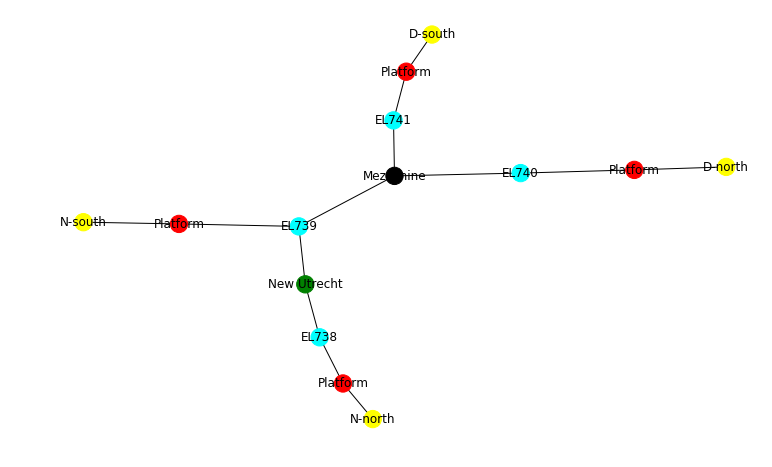

In [252]:
stations = [
#    '14 St - Union Sq',
#    '149 St - 3 Av',
#    'Simpson St',
#    '42 St - Port Authority Bus Terminal',
#      '125 St',
#    '86 St',
#    'World Trade Center',
#    '34 St - Penn',
#    'Lexington Av / 63 St',
#    'Dekalb Av',
#    'Fulton St',
    'New Utrecht',
    
]

g = add_to_graph(nx.Graph(), stations)

labels={node : attrs.get('label', 'Missing') for node, attrs in g.nodes(True)}
color_map = {'Street' : 'green', 'Elevator' : 'cyan', 'Platform' : 'red', 'Train' : 'yellow'}
colors=[color_map.get(attrs.get('node_type', 'Missing'), 'black') for _, attrs in g.nodes(True)]
plt.figure(figsize=(10,6)) 
nx.draw(g, with_labels=True, labels=labels, node_color=colors)


In [253]:
g = add_to_graph(nx.Graph(), None)
nx.write_graphml(g, DATA_DIR+'data/processed/mta-elevators.graphml')
elevators[['station_name','equipment_id','from','to','platform_id']].to_csv(
    DATA_DIR+'data/processed/mta-elevators-graph.csv', index=False)

# Debugging cells

In [254]:
elevators[(elevators['from'] == 'Unknown') | (elevators['to'] == 'Unknown')]

,connection_to_street,description,equipment_id,from,platform_id,station_name,to,fqn_from,fqn_to,label_from,label_to
137,N,Plaza south of Bowling Green Park for service ...,EL710,Street,NaN,Bowling Green,Unknown,Street-Bowling Green,Unknown-Bowling Green,Bowling Green,Unknown
160,N,ADA access to the N line Platform in combinati...,EL702,Unknown,N-south/N-north,Coney Island Stillwell Av,Platform,Unknown-Coney Island Stillwell Av,Platform-Coney Island Stillwell Av-N-south/N-n...,Unknown,Platform
161,N,ADA access to the N line Platform in combinati...,EL701,Unknown,N-north/N-south,Coney Island Stillwell Av,Platform,Unknown-Coney Island Stillwell Av,Platform-Coney Island Stillwell Av-N-north/N-s...,Unknown,Platform
199,N,Fulton St & Franklin Ave (SW corner) to transf...,EL339,Street,NaN,Franklin Av,Unknown,Street-Franklin Av,Unknown-Franklin Av,Franklin Av,Unknown


In [255]:
raw_elevators = pd.read_csv(DATA_DIR+'data/interim/crosswalks/EE_master_list.csv')
raw_elevators = raw_elevators[ (raw_elevators.equipment_type == 'EL') ]
raw_elevators[raw_elevators['station_name'] == 'Fulton St']


,Unnamed: 0,station_name,equipment_id,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,subset_lines,connection_to_street,st_name_opd_format,line,notes,geometry,lat,lon
375,375,Fulton St,EL728X,Dey St & Broadway (SW corner) to downtown 4/5 ...,MN,4/5,EL,Y,Y,downtown,4/5,N,Fulton St,4-5,"4-all times, 5-weekdays",POINT (-74.00950899856461 40.71036799882214),40.710368,-74.009509
376,376,Fulton St,EL718X,Entrance in Transit Center building (near Broa...,MN,A/C/J/Z/2/3/4/5,EL,Y,Y,uptown,A/C/J/Z/2/3/4/5,N,Fulton St,A-C,"A-all times, C-all times exc nights",POINT (-74.00762309323994 40.71016216530185),40.710162,-74.007623
377,377,Fulton St,EL717X,Entrance in Transit Center building (near Broa...,MN,A/C/J/Z/2/3/4/5,EL,Y,Y,uptown,A/C/J/Z/2/3/4/5,N,Fulton St,A-C,"A-all times, C-all times exc nights",POINT (-74.00762309323994 40.71016216530185),40.710162,-74.007623
378,378,Fulton St,EL723,Fulton St & William St (SW corner) to Mezzanin...,MN,2/3,EL,Y,Y,both directions,2/3,Y,Fulton St,2-3,"2-all times, 3-all times exc nights",POINT (-74.00657099970202 40.70941599925865),40.709416,-74.006571
382,382,Fulton St,EL719,Mezzanine (below Nassau St at level of downtow...,MN,A/C/J/Z/2/3/4/5,EL,Y,Y,downtown,A/C/J/Z/2/3/4/5,N,Fulton St,A-C,"A-all times, C-all times exc nights",POINT (-74.00762309323994 40.71016216530185),40.710162,-74.007623
383,383,Fulton St,EL721,Mezzanine and A/C Platforms and downtown J/Z s...,MN,A/C/J/Z/2/3/4/5,EL,Y,Y,downtown,A/C/J/Z/2/3/4/5,N,Fulton St,A-C,"A-all times, C-all times exc nights",POINT (-74.00762309323994 40.71016216530185),40.710162,-74.007623
384,384,Fulton St,EL732,Mezzanine to 2/3 Platform for service in both ...,MN,2/3,EL,Y,Y,both directions,2/3,N,Fulton St,2-3,"2-all times, 3-all times exc nights",POINT (-74.00657099970202 40.70941599925865),40.709416,-74.006571
385,385,Fulton St,EL729X,Mezzanine to downntown 4/5 Platform and access...,MN,4/5,EL,Y,Y,NaN,4/5,N,Fulton St,4-5,"4-all times, 5-weekdays",POINT (-74.00950899856461 40.71036799882214),40.710368,-74.009509
386,386,Fulton St,EL716,Mezzanine to Platforms for uptown 4/5 and J/Z ...,MN,4/5,EL,Y,Y,uptown,4/5,N,Fulton St,4-5,"4-all times, 5-weekdays",POINT (-74.00950899856461 40.71036799882214),40.710368,-74.009509
387,387,Fulton St,EL720,Mezzanine to uptown J/Z Platform to A/C Platfo...,MN,A/C/J/Z/2/3/4/5,EL,Y,Y,uptown,A/C/J/Z/2/3/4/5,N,Fulton St,A-C,"A-all times, C-all times exc nights",POINT (-74.00762309323994 40.71016216530185),40.710162,-74.007623


In [256]:
elevators[elevators['station_name'] == '190th St']

,connection_to_street,description,equipment_id,from,platform_id,station_name,to,fqn_from,fqn_to,label_from,label_to


In [257]:
list(elevators[ elevators.station_name == 'Coney Island Stillwell Av' ]["description"])

['ADA access to the N line Platform in combination with EL701 and a crossover bridge over the tracks',
 'ADA access to the N line Platform in combination with EL702 and a crossover bridge over the tracks']

In [258]:
# Merge in the override data
override_elevators = pd.read_csv(DATA_DIR+'data/raw/elevator-override.csv')

elevators = elevators.merge(override_elevators, how='outer')

elevators

,connection_to_street,description,equipment_id,from,platform_id,station_name,to,fqn_from,fqn_to,label_from,label_to
0,Y,125 St & Lexington Ave (NE corner) to Mezzanin...,EL125,Street,NaN,125 St,Mezzanine,Street-125 St,Mezzanine-125 St,125 St,Mezzanine
1,Y,125 St & St Nicholas Ave (SW corner) to Mezzan...,EL142,Street,NaN,125 St,Mezzanine,Street-125 St,Mezzanine-125 St,125 St,Mezzanine
2,N,Mezzanine to downtown Platform,EL143,Mezzanine,A-south/D-south/B-south/C-south,125 St,Platform,Mezzanine-125 St,Platform-125 St-A-south/D-south/B-south/C-south,Mezzanine,Platform
3,N,Mezzanine to Platforms for service in both dir...,EL126,Mezzanine,5-south/4-north/5-north/METRO-NORTH-south/METR...,125 St,Platform,Mezzanine-125 St,Platform-125 St-5-south/4-north/5-north/METRO-...,Mezzanine,Platform
4,N,Mezzanine to uptown Platform,EL144,Mezzanine,C-north/B-north/A-north/D-north,125 St,Platform,Mezzanine-125 St,Platform-125 St-C-north/B-north/A-north/D-north,Mezzanine,Platform
5,N,Lenox Ave & 181 St (NE corner) to uptown Platform,EL180,Street,3-north/2-north,135 St,Platform,Street-135 St,Platform-135 St-3-north/2-north,135 St,Platform
6,N,Lenox Ave & 181 St (SW corner) to downtown Pla...,EL181,Street,3-south/2-south,135 St,Platform,Street-135 St,Platform-135 St-3-south/2-south,135 St,Platform
7,N,8th Ave & 14 St (SW corner) to Mezzanine for s...,EL221,Street,NaN,14 St - 8 Av,Mezzanine,Street-14 St - 8 Av,Mezzanine-14 St - 8 Av,14 St - 8 Av,Mezzanine
8,N,Mezzanine to downtown A/C/E Platform,EL222,Mezzanine,E-south/A-south/C-south,14 St - 8 Av,Platform,Mezzanine-14 St - 8 Av,Platform-14 St - 8 Av-E-south/A-south/C-south,Mezzanine,Platform
9,N,Mezzanine to uptown A/C/E Platform,EL223,Mezzanine,E-north/A-north/C-north,14 St - 8 Av,Platform,Mezzanine-14 St - 8 Av,Platform-14 St - 8 Av-E-north/A-north/C-north,Mezzanine,Platform


In [259]:
raw_elevators.station_name.unique()

array(['125 St', '135 St', '14 St - 8 Av', '14 St - Union Sq',
       '149 St - 3 Av', '161 St - Yankee Stadium', '168 St', '175 St',
       '179 St - Jamaica', '181 St', '190 St', '191 St',
       '207 St - Inwood', '21 St - Queensbridge', '23 St', '231 St',
       '233 St', '28 St', '34 St - Herald Sq', '34 St - Hudson Yards',
       '34 St - Penn', '42 St - Bryant Park', '42 St - Grand Central',
       '42 St - Port Authority Bus Terminal',
       '47-50 St - Rockefeller Ctr', '49 St', '50 St', '51 St',
       '57 St - 7 Av', '59 St - Columbus Cir', '61 St - Woodside',
       '66 St - Lincoln Center', '68 St / Hunter College', '72 St',
       '72 St / 2 Av', '74 St - Broadway / Roosevelt Av', '8 Av',
       '8 Av - 14 St', '86 St', '86 St / 2 Av', '96 St', '96 St / 2 Av',
       'Aqueduct Racetrack', 'Atlantic Av-Barclays Ctr', 'Bay Parkway',
       'Bedford Park Blvd/Grand Concourse Line', 'Borough Hall',
       'Bowling Green', 'Briarwood/Van Wyck Blvd',
       'Broadway-Lafayette